In [1]:
import tensorflow as tf
import keras.models as mod
import keras.layers as lyr
import keras.optimizers as opt
import keras.losses as loss
import keras.metrics as met
import keras.regularizers as reg
from keras import backend as K
import keras.initializers as init
import keras.callbacks as call
import numpy as np
import albumentations
import cv2
import os
import pickle
import time
import cupy as cp
import re
import matplotlib.pyplot as plt
import math
from keras_tqdm import TQDMNotebookCallback
from numba import cuda
import gc
# Literally had to restart computer for Cupy to work...
# https://github.com/explosion/spaCy/issues/2778
# Docs here: https://docs-cupy.chainer.org/en/stable/index.html
# Will probably need to restart computer each time the kernel 
# resets to get Cupy to work...

Using TensorFlow backend.


In [2]:
# Supposedly frees GPU memory: https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/discussion/96876
cuda.select_device(0)
cuda.close()

# I. Preprocessing Definition

Rescaled and cropped in the terminal with `convert`. The scripts is called `preprocess_images.sh` and can be found in the `Datasets/ILSVRC2012/` folder. The script itself contains comments explaining how the command works and sources of inspiration.

After that we can calculate the PCA over all the pixels and store the resulting eigenvectors in a pickle file. It seems that the cropping augmentation is truly random so we will treat it as such and use the pre-built one in albumentations. We will also add a step in our custom (Sequence-class based) augmentator that adds the PCA noise. We just need to double check whether the input to this class is a np.array, tensor, or something else.

See: 
+ [Custom Augmentations With Keras][1]: How to use the Keras [Sequence][2] class to create custom image augmentations (beyond those built into Keras, including those from Albumentations).
+ [PCA On Alexnet Training Data][3]: Found this because I wanted to confirm the interpretation that RGB PCA should be taken over all pixels. Thought it could be taken over each pixel separately too. Read a paper somewhere making the point that the statistics of pixels should be locationally invariant. This makes sense since the color palette and brightness of an image set should overall not correlate with specific locations of the pixels assuming there isn't some strong correlation between the photographic lighting or color conditions (i.e. same photo studio or such). This is the theoretical motivation for taking the PCA over all pixels irrespective of their location in their images. 
+ [Augmentations: A Library For Augmenting Image Data][4]: Created by Kaggle competitors, this library is hella dope. Worth looking at their Github to see their featured examples of transformations. Really fun things you can do with images.

[1]: https://medium.com/the-artificial-impostor/custom-image-augmentation-with-keras-70595b01aeac
[2]: https://github.com/keras-team/keras/blob/04cbccc8038c105374eef6eb2ce96d6746999860/keras/utils/data_utils.py
[3]: https://deshanadesai.github.io/notes/Fancy-PCA-with-Scikit-Image
[4]: https://albumentations.readthedocs.io/en/latest/api/augmentations.html

## I.a) Calculating mean

Note that if $X_i$ denotes the length three vector of RGB values for pixel $i$ in our image set, and $\bar{X}$ denote the mean of the random vector $X$ then:

$$
\begin{align}
\bar{X} &= \frac{1}{N} \sum_{i}  X_i \\
\end{align}
$$

So the mean of $X$ can be calculated additively! This is what we do, in order to not overflow the memory of this notebook.

In [2]:
# Number of class folders
!ls Datasets/ILSVRC2012/Training | wc -l

1001


In [3]:
root_dir = "Datasets/ILSVRC2012/Training/"
class_dirs = [class_dir for class_dir in os.listdir(root_dir)
              if class_dir[-4:] != ".tar"]
assert len(class_dirs) == 1000, """Not exactly 1000 classes were found!
                                   {} classes were found instead 
                                """.format(len(class_dirs))

num_pixels = 0
sum_pixels = cp.array([0.0,0.0,0.0])

t_job_start = time.time()
delta_ts = []

# Using the GPU shaves 30% (10 minutes) from the total calculation!
# Could be more if im.read created a cp.array directly? 
# Doesn't seem supported though, by OpenCV
for num, class_dir in enumerate(class_dirs):
    t_dir_start = time.time()
    
    full_class_path = root_dir + class_dir + '/'
    class_images = [image for image in os.listdir(full_class_path)
                    if image[-5:] == ".JPEG"]
    
    for image in class_images:
        image_path = full_class_path + image
        pixel_array = cp.array(cv2.imread(image_path)).reshape(-1, 3)
        
        sum_pixels += pixel_array.sum(axis=0)
        num_pixels += pixel_array.shape[0]
    
    t_dir_end = time.time()
    delta_t = (t_dir_end - t_dir_start)/60
    delta_ts.append(delta_t)
    avg_delta_t = round(sum(delta_ts)/len(delta_ts), 2)

    print("""
    Iteration #{} Completed in {} minutes.
    Average iteration time: {} minutes
    Estimated time remaining: {} minutes
    """.format(num + 1, 
               round(delta_t, 2),
               avg_delta_t,
               avg_delta_t * (1000 - (num-1))
               ))
        
results = {
    'sum_pixels': sum_pixels,
    'num_pixels': num_pixels,
    'pixel_avg': sum_pixels/num_pixels
}

with open('pixel_avg.pkl', 'wb') as file:
    pickle.dump(results, file)


    Iteration #1 Completed in 0.02 minutes.
    Average iteration time: 0.02 minutes
    Estimated time remaining: 20.02 minutes
    

    Iteration #2 Completed in 0.02 minutes.
    Average iteration time: 0.02 minutes
    Estimated time remaining: 20.0 minutes
    


KeyboardInterrupt: 

In [ ]:
print("Total time: {} minutes".format(round(sum(delta_ts), 2)))

In [2]:
results = None
with open('pixel_avg.pkl', 'rb') as file:
    results = pickle.load(file)
    
print(results)

{'sum_pixels': array([8.33242389e+12, 9.38175940e+12, 9.93350039e+12]), 'num_pixels': 80670566851, 'pixel_avg': array([103.289517  , 116.29717962, 123.13661324])}


In [3]:
pixel_avg = results['pixel_avg']
pixel_avg

array([103.289517  , 116.29717962, 123.13661324])

## I.b) Calculating covariance

Let $C(X)$ be the covariance of X, then:

$$
\begin{align}
C(X) &= \frac{1}{N-1} \sum_{i} \left(X_i - \bar{X}\right)\left(X_i - \bar{X}\right)^{T} \\
     &= \frac{1}{N-1} \sum_{i} X_i X_i^{T}, \text{ if } \bar{X}=\vec{0}
\end{align}
$$

Thus the covariance can also be calculated additively:

In [ ]:
root_dir = "Datasets/ILSVRC2012/Training/"
class_dirs = [class_dir for class_dir in os.listdir(root_dir)
              if class_dir[-4:] != ".tar"]
assert len(class_dirs) == 1000, """Not exactly 1000 classes were found!
                                   {} classes were found instead 
                                """.format(len(class_dirs))

num_pixels = 0
sum_cov = cp.array([[0.0,0.0,0.0],
                    [0.0,0.0,0.0],
                    [0.0,0.0,0.0]])

t_job_start = time.time()
delta_ts = []

# Would be good to refactor this and the above into a couple
# of methods
for num, class_dir in enumerate(class_dirs):
    t_dir_start = time.time()
    
    full_class_path = root_dir + class_dir + '/'
    class_images = [image for image in os.listdir(full_class_path)
                    if image[-5:] == ".JPEG"]
    
    for image in class_images:
        image_path = full_class_path + image
        pixel_array = cp.array(cv2.imread(image_path)).reshape(-1, 3)
        
        # Mean needs to be subtracted for PCA
        sum_cov += cp.matmul((pixel_array - pixel_avg).T, 
                             pixel_array - pixel_avg)
        num_pixels += pixel_array.shape[0]
    
    t_dir_end = time.time()
    delta_t = (t_dir_end - t_dir_start)/60
    delta_ts.append(delta_t)
    avg_delta_t = round(sum(delta_ts)/len(delta_ts), 2)

    print("""
    Iteration #{} Completed in {} minutes.
    Average iteration time: {} minutes
    Estimated time remaining: {} minutes
    """.format(num + 1, 
               round(delta_t, 2),
               avg_delta_t,
               avg_delta_t * (1000 - (num-1))
               ))
        
results = {
    'sum_cov': sum_cov,
    'num_pixels': num_pixels,
    'cov': sum_cov/(num_pixels - 1)
}

with open('cov.pkl', 'wb') as file:
    pickle.dump(results, file)

In [ ]:
print("Total time: {} minutes".format(round(sum(delta_ts), 2)))

In [4]:
cov_results = None
with open('cov.pkl', 'rb') as file:
    cov_results = pickle.load(file)
    
print(cov_results)

{'sum_cov': array([[4.21188577e+14, 3.60446585e+14, 3.12017459e+14],
       [3.60446585e+14, 3.83212549e+14, 3.49846292e+14],
       [3.12017459e+14, 3.49846292e+14, 4.05591044e+14]]), 'num_pixels': 80670566851, 'cov': array([[5221.0935589 , 4468.13006907, 3867.79802647],
       [4468.13006907, 4750.33911837, 4336.72782218],
       [3867.79802647, 4336.72782218, 5027.74506138]])}


In [5]:
# The covariances roughly align with the precalculated values used here
# https://medium.com/@kushajreal/training-alexnet-with-tips-and-checks-on-how-to-train-cnns-practical-cnns-in-pytorch-1-61daa679c74a
cov = cov_results['cov']
cp.power(cov, 0.5)

array([[72.257135  , 66.8440728 , 62.19162344],
       [66.8440728 , 68.92270394, 65.85383681],
       [62.19162344, 65.85383681, 70.90659392]])

In [6]:
stdev = cp.sqrt(cov.diagonal()/255**2)
stdev

array([0.28336131, 0.27028511, 0.27806507])

## I.c) Calculating PCA

The principal components are just the eigenvectors of the covariance matrix! For more information see the "Further Considerations" section in the [PCA Wikipedia article][5]. Note that here we normalize the pixel values by dividing them by 255. Since the covariance is quadratic in the pixel values this is equivalent to dividing the covariance matrix by 255.

[5]:  https://en.wikipedia.org/wiki/Principal_component_analysis#Covariances

In [7]:
# Note that the eigenvectors returned are normalized
eigenvalues, eigenvectors = cp.linalg.eigh(cov/255**2)

print("The eigenvalues and eigenvectors are: ")
for index in range(len(eigenvalues)):
    print("Eigenvalue {} with eigenvector {}".format(eigenvalues[index],
                                                     eigenvectors[index]))

The eigenvalues and eigenvectors are: 
Eigenvalue 0.004514740525446098 with eigenvector [-0.42554244  0.69241432 -0.58264573]
Eigenvalue 0.019308944111807815 with eigenvector [ 0.81311549  0.00997301 -0.58201696]
Eigenvalue 0.20684417754890627 with eigenvector [-0.39718615 -0.72143118 -0.56725675]


We will probably want to normalize the mean and covariance tensors by dividing them by $255$ and $255^2$ respectively. That should help normalize the gradients in the training most likely. We should take a look at whether Keras does this scaling automatically for image data or not.

We also need to create the Lambda layer for subtracting the mean, as well as the custom augmentation layer that adds the random PCAs and does crops/flips.

# II. Define Data Augmentations

With the eigenvectors in hand we can use them along with the Albumentations library to augment our data as descriped in the paper. We use a custom subclass of the Sequence class to do the augmentations. We pass this class to the `fit_generator` method of our model class.

In [8]:
from keras.utils import Sequence

In [9]:
class AlexNetSequence(Sequence):
    def __init__(self, x_paths, y_labels, batch_size, 
                 images_dir, eigenvectors, eigenvalues,
                 pixel_avg, stdev, mode):
        """
        We initialize the AlexNetSequence class by
        passing it all of the paths to the images we 
        use for training along with a matching array 
        with the class labels.
        
        The sequence class itself takes care of taking
        the paths in a mini-batch and converting them
        to the correspoding image arrays.
        """
        self.x_paths, self.y_labels = x_paths, y_labels
        self.batch_size = batch_size
        self.images_dir = images_dir
        self.eigenvectors = eigenvectors
        self.eigenvalues = eigenvalues
        self.pixel_avg = pixel_avg
        self.stdev = stdev
        self.mode = mode

    def __len__(self):
        """
        We appear to define the length of a sequence
        to be (approximately) the number of batches in
        said sequence. 
        
        This is likely the case so that there is a clear
        number of iterations defined for each epoch by
        the Sequence itself.
        
        The docs say this is one of the methods that MUST
        be implemented by any custom Sequence subclass.
        """
        return int(np.ceil(len(self.x_paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        """
        The second method required to be implemented by
        the Sequence interface. This is the method used to
        generate minibatches.
        
        In this method we take a minibatch of image paths,
        convert them to arrays, apply our augmentations, and
        then return the augmented image array batch.
        """
        x_batch_paths = self.x_paths[idx * self.batch_size:(idx + 1) *
                                     self.batch_size]
        
        x_batch = np.stack([self.aug(cv2.imread(self.images_dir + x_path))
                            for x_path in x_batch_paths], axis=0)
        
        y_batch = self.y_labels[idx * self.batch_size:(idx + 1) *
                                self.batch_size]
                
        return x_batch, y_batch
    
    @staticmethod
    def pad_image(image, x_pad_to=224, y_pad_to=224):
        pad_vals = ((0,0),(0,0),(0,0))
        width, height = image.shape[0], image.shape[1]
        
        pad_x, pad_y = max(x_pad_to - width, 0), max(y_pad_to - height, 0)
        pad_x_upper, pad_x_lower = int(math.ceil(pad_x/2)), int(math.floor(pad_x/2))
        pad_y_upper, pad_y_lower = int(math.ceil(pad_y/2)),   int(math.floor(pad_y/2))
        
        assert pad_x_upper + pad_x_lower == pad_x, "Error with horizontal padding"
        assert pad_y_upper + pad_y_lower == pad_y, "Error with vertical padding"
        
        pad_dims = ((pad_x_upper, pad_x_lower),(pad_y_upper, pad_y_lower),(0,0))
        
        return np.pad(image, pad_dims, 'constant', constant_values=pad_vals)
    
    @staticmethod    
    def train_augment(image, eigenvectors, eigenvalues, pixel_avg, stdev):
        """
        Takes an image from the training set, applies a random
        224 x 224 crop and a horizontal flip with 50% probability.
        Additionally it sums a random linear combination of the 
        eigenvectors of all the pixels in the training set to all
        of the pixels in the training image. We also normalize the 
        pixel values.
        
        Since we are not generating all of the possible transformation
        combinations (but only randomly returning a single one), do 
        we need more epochs or do we sample more times each epoch?
        """
        
        width, height = image.shape[0], image.shape[1]
        
        crop_width = min(224, width)
        crop_height = min(224, height)
        
        augmenter = albumentations.Compose([
                                    albumentations.RandomCrop(crop_width, crop_height),
                                    albumentations.HorizontalFlip()
                                ])
        alphas = np.random.normal(scale=0.1, size=3)
        shift = np.zeros(3)
        
        for i in range(3):
            shift += alphas[i] * eigenvalues[i] * eigenvectors[i]
            
        output_image = ((augmenter(image=image)["image"]-pixel_avg)/255)/stdev + shift
                
        return AlexNetSequence.pad_image(output_image)
    
    @staticmethod
    def validate_augment(image, pixel_avg, stdev):
        """
        Simply normalize image values and do a crop.
        """
        width, height = image.shape[0], image.shape[1]
        
        crop_width = min(224, width)
        crop_height = min(224, height)
        
        augmenter = albumentations.Compose([
                                    albumentations.CenterCrop(crop_width, crop_height)])
        
        output_image = ((augmenter(image=image)["image"]-pixel_avg)/255)/stdev
        
        return AlexNetSequence.pad_image(output_image)
    
    def aug(self, image):
        """
        A succinct method for convenience. The static one
        is useful for playing around with data in the notebook.
        
        Since our goal is not to try out different augmentations
        but just to reproduce those in paper, we have hardcoded
        our augmentation choices into this class. We could parametrize
        them in the constructor instead to accomplish the former
        goal.
        """
        if self.mode == "train":
            return AlexNetSequence.train_augment(image,
                                                 self.eigenvectors,
                                                 self.eigenvalues,
                                                 self.pixel_avg,
                                                 self.stdev)
        elif self.mode == "validate":
            return AlexNetSequence.validate_augment(image,
                                                    self.pixel_avg,
                                                    self.stdev)
        
        else:
            raise ValueError("The `mode` parameter passed to the "
                             "constructor must be one of [`train`, `validate`]")

# III. Model Definition

In [10]:
import keras
dir(keras.layers)

['Activation',
 'ActivityRegularization',
 'Add',
 'AlphaDropout',
 'AtrousConvolution1D',
 'AtrousConvolution2D',
 'Average',
 'AveragePooling1D',
 'AveragePooling2D',
 'AveragePooling3D',
 'AvgPool1D',
 'AvgPool2D',
 'AvgPool3D',
 'BatchNormalization',
 'Bidirectional',
 'Concatenate',
 'Conv1D',
 'Conv2D',
 'Conv2DTranspose',
 'Conv3D',
 'Conv3DTranspose',
 'ConvLSTM2D',
 'ConvLSTM2DCell',
 'ConvRecurrent2D',
 'Convolution1D',
 'Convolution2D',
 'Convolution3D',
 'Cropping1D',
 'Cropping2D',
 'Cropping3D',
 'CuDNNGRU',
 'CuDNNLSTM',
 'Deconvolution2D',
 'Deconvolution3D',
 'Dense',
 'DepthwiseConv2D',
 'Dot',
 'Dropout',
 'ELU',
 'Embedding',
 'Flatten',
 'GRU',
 'GRUCell',
 'GaussianDropout',
 'GaussianNoise',
 'GlobalAveragePooling1D',
 'GlobalAveragePooling2D',
 'GlobalAveragePooling3D',
 'GlobalAvgPool1D',
 'GlobalAvgPool2D',
 'GlobalAvgPool3D',
 'GlobalMaxPool1D',
 'GlobalMaxPool2D',
 'GlobalMaxPool3D',
 'GlobalMaxPooling1D',
 'GlobalMaxPooling2D',
 'GlobalMaxPooling3D',
 'High

In [11]:
def lrn_parametric(tensor, k, n, alpha, beta):
    """
    Check that parameters make sense (note n/2 describes 
    the number of adjacent layers on each side to normalize by)
    """
    assert n >= 1 # n < 0 doesn't make sense, n = 0 (when k = 0) makes the layer output constant
    assert k > 0  # If k = 0 we can get div by zero errors or numeric instability 
    assert alpha > 0 # alpha = 0 is equivalent to reducing the layer to scalar division
    assert beta > 0 # beta = 0 is equivalent to removing this layer
    
    tf_session = K.get_session()
    
    """
    First dimension is batches, second and third are spatial, 
    fourth should be layers
    """
    shape = tensor.get_shape().as_list()
    assert len(shape) == 4 # Make sure shape is (batch, x, y, map)
    N = shape[3]
    
    """
    For layer i only the layers i +/- int_step fall within 
    the range defined by the sum formula in the paper
    """
    int_step = n/2 - (n/2 % 1)
    
    """
    These tensors correspond to i, the sum lower bounds, 
    and upper bounds respectively
    """
    i = np.arange(N)
    j_lower = np.maximum(0, i - int_step).reshape(-1,1)
    j_upper = np.minimum(N - 1, i + int_step).reshape(-1,1)
    
    """
    Create a tensor Mij such that Mij = 1 if j_lower(i) <= j <= j_upper(i) and is 0 otherwise
    If a_{xy}^j is the convolution output then M_{ij}a_{xy}^j gives the 
    lrn normalization coefficient
    """
    mask_ij = np.repeat(np.arange(N).reshape(1,-1), N, axis=0)
    mask_ij = np.logical_and(mask_ij >= j_lower, mask_ij <= j_upper).astype(int)
    mask_ij = K.variable(mask_ij)
    
    """
    Calculate the  norm tensor, denominator, and finally 
    output tensor of LRN. Note that even because K is a Keras 
    wrapper around Tensorflow, we can use tf methods on tensors 
    created with K. This is because K generated objects are 
    really tf objects
    """
    lrn_norm = tf.einsum('bxyj,ij->bxyi', K.pow(tensor,2), mask_ij)
    denom = K.pow(k + alpha * lrn_norm, beta)
    lrn_output = tensor/denom
    
    return lrn_output
    
def lrn_shape(input_shape):
    return input_shape

In [12]:
k, n, alpha, beta = 2, 5, 10**(-4), 0.75
lrn = lambda tensor: lrn_parametric(tensor, k, n, alpha, beta)

Following what was done in the paper we initialize all of the weights in our Alexnet with a random Gaussian with mean zero and standard deviation $0.01$. The biases for the 2nd, 4th, 5th, and fully connected layers are set to $1$, and the biases for the 1st and 3rd layer to $0$. Here we refer to the weights and biases of the convolutional layers only. Doing this accelerates training according to the authors, since it gives the ReLu activations a non-zero starting value. This [github post][6] shows how to set non-default initialization values.

We also apply weight decay in the layers. Keras takes weight decay at the layer level so we apply the same decay to each layer. We are not sure whether the decay should apply only to the weights or also to the biases. We apply them to both. This [github post][8] explains how weight decay leads to the gradient term described in the paper.

[6]: https://datascience.stackexchange.com/questions/19019/custom-weight-initialization-in-keras
[8]: https://stats.stackexchange.com/questions/29130/difference-between-neural-net-weight-decay-and-learning-rate

In [13]:
alexnet = mod.Sequential(
 [# We input 224 x 224 pixel images with 3 channels (rgb)
  # We create 96 feature maps, by using an 11x11 pixel kernel with stride 4
  lyr.Conv2D(96, 11, strides=4, padding='same', 
             input_shape=(224, 224, 3,), activation='relu',
             kernel_initializer=init.TruncatedNormal(stddev=0.00), #current: init.he_uniform()
             bias_initializer=init.Zeros(),
             kernel_regularizer=reg.l2(0.0005),
             bias_regularizer=reg.l2(0.005)),
  # The lambdas here are the local response normalization
  lyr.Lambda(lrn, output_shape=lrn_shape),
  lyr.MaxPool2D(3,2),
  lyr.Conv2D(256, 5, strides=1, padding='same', activation='relu',
             kernel_initializer=init.TruncatedNormal(stddev=0.00), #current: init.he_uniform()
             bias_initializer=init.Ones(),
             kernel_regularizer=reg.l2(0.0005),
             bias_regularizer=reg.l2(0.005)),
  lyr.Lambda(lrn, output_shape=lrn_shape),
  lyr.MaxPool2D(3,2),
  lyr.Conv2D(384, 3, strides=1, padding='same', activation='relu',
             kernel_initializer=init.TruncatedNormal(stddev=0.00), #current: init.he_uniform()
             bias_initializer=init.Zeros(),
             kernel_regularizer=reg.l2(0.0005),
             bias_regularizer=reg.l2(0.005)),
  lyr.Conv2D(384, 3, strides=1, padding='same', activation='relu',
             kernel_initializer=init.TruncatedNormal(stddev=0.00), #current: init.he_uniform()
             bias_initializer=init.Ones(),
             kernel_regularizer=reg.l2(0.0005),
             bias_regularizer=reg.l2(0.005)),
  lyr.Conv2D(256, 3, strides=1, padding='same', activation='relu',
             kernel_initializer=init.TruncatedNormal(stddev=0.00), #current: init.he_uniform()
             bias_initializer=init.Ones(),
             kernel_regularizer=reg.l2(0.0005),
             bias_regularizer=reg.l2(0.005)),
  # Note from the diagram there is one last pool op after the last conv
  lyr.MaxPool2D(3,2),
  lyr.Flatten(),
  lyr.Dense(4096, activation='relu',
            kernel_initializer=init.TruncatedNormal(stddev=0.00), #current: init.he_uniform()
            bias_initializer=init.Ones(),
            kernel_regularizer=reg.l2(0.0005),
            bias_regularizer=reg.l2(0.005)),
  # The paper says the first two dense layers are regularized with dropout
  lyr.Dropout(0.5),
  lyr.Dense(4096, activation='relu',
            kernel_initializer=init.TruncatedNormal(stddev=0.00), #current: init.he_uniform()
            bias_initializer=init.Ones(),
            kernel_regularizer=reg.l2(0.0005),
            bias_regularizer=reg.l2(0.005)),
  lyr.Dropout(0.5),
  lyr.Dense(1000, # DEBUG - Can change to smaller number of classes for debugging
            activation='softmax',
            kernel_initializer=init.TruncatedNormal(stddev=0.00), #current: init.he_uniform()
            bias_initializer=init.Ones(),
            kernel_regularizer=reg.l2(0.0005),
            bias_regularizer=reg.l2(0.005))
 ]
)


W0228 22:26:06.489115 140624815589184 deprecation_wrapper.py:119] From /home/daniel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [14]:
alexnet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 56, 56, 96)        34944     
_________________________________________________________________
lambda_1 (Lambda)            (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
lambda_2 (Lambda)            (None, 27, 27, 256)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 384)      

# IV. Training

We implement the training using Stochastic Gradient Descent with a batch size of $128$, momentum of $0.9$, and an initial learning rate of $0.01$ as specified in the paper. We use categorical crossentropy as our loss function, which is the standard for classification and what other examples on the web have used to train Alexnet. Our performance metric is the top 1 and top 5 error, which is what was used in the paper. 

We do not used [Nesterov Momentum][7] in our model as it was not used in the paper. Nesterov momentum is a type of "lookahead" momentum that calculates the gradient at a point ahead in the direction of the momentum.  This way if the momentum will cause the descent step update to overshoot the minimum, the look ahead gradient will partially cancel out the effect of the momentum. We use a [shell script][9] to calculate the number of training files and hence the number of minibatches.

We implement the learning rate heuristic by using Keras [callbacks][10]. Callbacks are functions that get called during training and get applied during the training procedure. They can be used for logging epochs, controlling the learning rate schedule, etc. In our case we will use them to:

+ Implement our learning rate heuristic, which has a built in class in Keras.
+ Checkpoint the model as we train it, so we don't loss progress upon failure. This is a best practice.
+ Log to the Tensorboard, so we can play around with it and visualize our training metrics!

[7]: https://dominikschmidt.xyz/nesterov-momentum/
[9]: https://www.shellhacks.com/count-number-files-directory/
[10]: https://keras.io/callbacks/

In [15]:
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata= tf.RunMetadata()

In [16]:
"""
Using zero built in decay and relying exclusively on the heuristic
used in the original paper.
"""
optimizer = opt.Adam() 
# This line below would match the paper exactly but was MUCH slower than using Adam on 2 class example
# opt.SGD(learning_rate=0.01, momentum=0.9, decay=0.0) # Note decay refers to learning rate

top_1_acc = met.categorical_accuracy

def top_5_acc(y_true, y_pred):
    return  met.top_k_categorical_accuracy(y_true, y_pred, k=5)

alexnet.compile(optimizer=optimizer,
                loss="categorical_crossentropy",
                metrics=[top_1_acc, top_5_acc],
                options=run_options,
                run_metadata=run_metadata)

In [17]:
# Count training images recursively in shell
num_images = !find ~/AnacondaProjects/AlexNet/datasets/ILSVRC2012/Training -type f -name "*.JPEG" | wc -l
num_img_int = int(num_images[0])

In [18]:
# Count training images recursively in shell
num_images_val = !find ~/AnacondaProjects/AlexNet/datasets/ILSVRC2012/Validation -type f -name "*.JPEG" | wc -l
num_img_val_int = int(num_images_val[0])

In [19]:
with open('datasets/ILSVRC2012/sysnet_words.txt', 'r') as file:
    words = file.readlines()
    
codes = [re.match('n[0-9]*', word).group() for word in words]
labels = [word.replace(code, '').strip() for word, code in zip(words, codes)]
code_label_map = dict(zip(codes, labels))
index_code_map = dict(enumerate(codes))
code_index_map = {code: index for index, code in index_code_map.items()}

Some nice explanations of the importance of shuffling mini-batches can be found in each of these references ([1][16],[2][17],[3][18]). The tl;dr is that if the mini-batch contents are too correlated then they don't provide a good estimator for the gradient. This eliminates the theoretical guarantees of SGD methods. Furthermore, empirical evidence shows that changing the order of mini-batches is also important in helping convergece. We do both below, one through an initial shuffling of the data and another by setting "shuffling" to True in the fit_generator method. 

[16]: https://stackoverflow.com/questions/40816721/should-i-shuffle-the-data-to-train-a-neural-network-using-backpropagation
[17]: https://datascience.stackexchange.com/questions/24511/why-should-the-data-be-shuffled-for-machine-learning-tasks
[18]: https://stats.stackexchange.com/questions/245502/shuffling-data-in-the-mini-batch-training-of-neural-network

In [20]:
# Get list of training and validation examples and labels
training_dir = "datasets/ILSVRC2012/Training/"
validation_dir = "datasets/ILSVRC2012/Validation/"
num_classes = len(code_index_map) # DEBUG Can fix to smaller number of classes for debugging

def get_paths_and_classes(root_dir, code_index_map=code_index_map):
    classes = []
    example_paths = []
    

    class_dirs = [class_dir for class_dir in os.listdir(root_dir)
                  if class_dir[-4:] != ".tar"] # DEBUG: [:n] takes first n classes for debugging

    for num, class_dir in enumerate(class_dirs):
        
        t_dir_start = time.time()

        full_class_path = root_dir + class_dir + '/'
        class_images = [class_dir + '/' + image for image in os.listdir(full_class_path)
                        if image[-5:] == ".JPEG"]
    
        example_paths.extend(class_images)
        class_index_list = [code_index_map[class_dir]]  # DEBUG: Can set equal to [num] for debugging smaller # classes
        classes.extend(len(class_images)*class_index_list)
        
        assert len(example_paths) == len(classes), "Number of labels must match number of examples"
        
    # https://stackoverflow.com/questions/38592324/one-hot-encoding-using-numpy
    classes_array = np.array([classes]).reshape(-1)
    one_hot_classes = np.eye(num_classes)[classes_array]
        
    return example_paths, one_hot_classes

x_paths_train, y_labels_train = get_paths_and_classes(training_dir)
x_paths_val, y_labels_val = get_paths_and_classes(validation_dir)

train_indices = np.random.choice(np.arange(len(x_paths_train)), size=len(x_paths_train), replace=False)
val_indices = np.random.choice(np.arange(len(x_paths_val)), size=len(x_paths_val), replace=False)

# Shuffle parameter in fit generator only shuffles minibatch order. Without shuffling ahead
# of time mini-batches will tend to be extremely correlated (i.e. same class) which will make
# our gradient estimate biased. 
x_paths_train, y_labels_train = np.array(x_paths_train)[train_indices].tolist(), y_labels_train[train_indices]
x_paths_val, y_labels_val =  np.array(x_paths_val)[val_indices].tolist(), y_labels_val[val_indices]

In [21]:
# We checked that we could overfit 1-10 minibatches by indexing [:k*128]
# in the x paths and y labels in the generators below! It worked :D

# scheduler = call.ReduceLROnPlateau() # Not needed when Adam used
tensorboard = call.TensorBoard(log_dir='alexnet/logs',
                               batch_size=128,
                               write_grads=True,
                               write_images=True)
checkpointer= call.ModelCheckpoint('alexnet/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                                   verbose=1)
tqdm = TQDMNotebookCallback()

# Added to address OOM Error
# See: https://github.com/keras-team/keras/issues/3675
garbage_collection = call.LambdaCallback(on_epoch_end=lambda epoch, logs: gc.collect())

train_gen = AlexNetSequence(x_paths_train, #x_paths
                            y_labels_train, #y_labels
                            128,
                            '/home/daniel/AnacondaProjects/AlexNet/datasets/ILSVRC2012/Training/',
                            np.array(eigenvectors.tolist()),
                            np.array(eigenvalues.tolist()),
                            np.array(pixel_avg.tolist()),
                            np.array(stdev.tolist()),
                            'train')
val_gen = AlexNetSequence(x_paths_val,
                          y_labels_val,
                          128,
                          '/home/daniel/AnacondaProjects/AlexNet/datasets/ILSVRC2012/Validation/',
                          np.array(eigenvectors.tolist()),
                          np.array(eigenvalues.tolist()),
                          np.array(pixel_avg.tolist()),
                          np.array(stdev.tolist()),
                          'validate')

### Notes on epoch slowness

It takes about 45 minutes for a single epoch of training to complete. We wanted to find benchmarks online to check whether this is a reasonable time.

+ 163 minutes per epoch according to [one source][11], although this did not factor data augmentation. The latter would multiply the time per epoch by 2048.


+ 86 minutes per epoch on a Titan Black GPU according to [another source][12]. This post was from 2016 so we would expect our newer GPU to perform better (though we're not sure exactly by how much).


+ 7 minutes per epoch according to the image per second rate quoted in [this benchmark][13] for FP32, using our exact same GPU (GE Force RTX 2080 Ti). We re-ran the benchmark in our computer (see Appendix A) with a batch size of 1,024 and found that we could be going even faster, at 5 minutes per epoch!! Using a batch size of 2,048 led to memory errors surprisingly.


+ With FP16 the same benchmark predicts an epoch time of 4.2 minutes. We attained basically this performance, using both batch sizes of 1,024 and 2,048. We were able to fit the latter size of image batches with FP16, which makes sense since FP16 should take half the memory of FP32.

We thus conclude that our implementation of this neural network is likely underoptimized. Likely culprits in order of likelihood are:

+ The custom LRN lambda layer we implemented. In practice for modern NNs this layer isn't used. However we implemented it to match exactly the original implementation of AlexNet as closely as possible. 
    + **We commented these out and the running time per image was still 45 minutes... It must not be this then.** 
    
    
+ The albumentations based sequence class. Given the popularity of this library we would be surprised if it were causing significant latency. However since it is not part of the TF or Keras core no guarantees come with it. 
    + **It's not the augmentation. We commented them out and replaced them with returning zeros Numpy arrays (which should be easy to propagate) and it only reduced epoch time by about 10%.**
    
    
+ The IO of reading images in may be a a bottleneck. 
    + **It is, eliminating this along with augmentation reduced the running time from 40 minutes per epoch to 20 minutes, so about 50% reduction from the non-augmentation best case and even more from the original.** 
    + **Additionally removing the lambda layers gets the time per epoch down to 15-17 minutes. Closer, but not quite the 5 minutes implied by the Alexnet benchmark.**
    + **Finally, increasing the minibatch size to 1024 takes the time down to a solid 13-14 minutes per epoch. This was the last major discrepancy. We attribute any remaining performance gap to optimizations in the deserialization and architecture of the AlexNet copy used in the performance test.**
    
Some other interesting but less useful benchmarks can be found [here][14] and [here][15]. We note we achieved the same slow images per second rate (~500) even when only using 2 classes. This makes us think the problem is not a memory one, since at a glance we think that number of images could fit in memory. We have to double check this though.

[11]: https://www.reddit.com/r/MLQuestions/comments/ahu204/how_long_does_it_take_to_run_an_epoch_of_alexnet/
[12]: https://github.com/vlfeat/matconvnet/issues/706
[13]: https://blog.exxactcorp.com/nvidia-rtx-2080-ti-deep-learning-benchmarks-for-tensorflow-updated-with-xla-fp16/
[14]: https://blog.exxactcorp.com/whats-the-best-gpu-for-deep-learning-rtx-2080-ti-vs-titan-rtx-vs-rtx-8000-vs-rtx-6000/
[15]: https://lambdalabs.com/blog/2080-ti-deep-learning-benchmarks/

### Notes on Trouble Fitting Two Classes (SGD Loss Plateau)

We noticed that in training AlexNet for a handful of epochs even with just two classes we didn't see the accuracy really improve beyond 50%. We followed [Josh Tobin's guide][19] on debugging networks and checked possible problems that could be causing the training to plateau. In the order we suspected them:

+ **Data or labels corrupted**: We checked the data to see if the labels matched the images. We did this by:
    + Checking the shuffled image-label pairs matched the unshuffled image label pairs. They did, so we knew the shuffling worked.
    + Checked the raw images manually to make sure the preprocessing or download didn't have any silent errors. They did not, the iamges at a glance looked fine.
    + Checked the image mini-batch preprocessing. We manually preprocessed a handful of images and visually inspected the augmented output. The output was as expected. This was our last data corruption concern.
    
    
+ **Incorrect input to the loss function**: We checked that we correctly used cross-entropy loss and that we used an output softmax. We cross-referenced other implementations online and found ours to agree with them.


+ **Too much regularization**: As a initial stab at this we removed the LRN layers to remove any potential custom layer bugs and over-normalization. Removing them did not address the issue. We did not suspect weight decay to be a problem so we didn't check removing it.


+ **Gradients not flowing through the whole model**: We honestly did not suspect this, simply out of trusting the original paper. However, **this was the problem**. Out of instinct we decided to play with the optimizer, noticed many other implementations used Adam, and tried Adam ourselves. Adam was able to attain 80% accuracy on 2 classes in about 20 epochs! In 200 it had reached 99% accuracy on the training set as desired (95% on validation). We went back to SGD and found that if we ran 200 epochs (which we hadn't done before) it did in fact reach about 89% accuracy on the training set (95% on validation), but only across 80% accuracy after about 160 epochs. With Nesterov momentum it took 90-100 epochs to reach 80%. Adam has consistently performed better -- we understand now that because of its auto-adaptive rate Adam performs better with deep networks having small gradients. This is the case with vision problems generally and hence **Adam is the recommended optimizer, which we are using now instead. Since Adam adapts we're also removing the learning schedule from the original AlexNet implementation.** The fact that SGD + Momentum + Nesterov & Adam perform well agrees with this [implentation's author][21].


+ **Learning rate too small**: We tried increasing the initial learning rate of SGD to 0.1 from 0.01 but then the loss became NaN. We opted to use Adam instead then.

[Here][20] is a fun article describing the different optimization techniques with demos! As a last note, we'll remark that in following the debugging recommendations of the aforementioned author, we tried fitting our model to a single mini-batch. However, we did so without shuffling the data, which meant the accuracy was trivially 1 because there was only one class to predict. Thus, it is important -- even if and especially when debugging -- to shuffle the data, otherwise debugging results can be very misleading. If testing NNs by fitting mini-batches, we should make sure to look at the loss rather than the accuracy.

[19]: http://josh-tobin.com/assets/pdf/troubleshooting-deep-neural-networks-01-19.pdf
[20]: https://ruder.io/optimizing-gradient-descent/index.html#adam
[21]: https://medium.com/@kushajreal/training-alexnet-with-tips-and-checks-on-how-to-train-cnns-practical-cnns-in-pytorch-1-61daa679c74a

### Notes on Trouble Fitting Five Classes (Poor Normalization + Better Initialization)

**Subtracting the Mean**

We knew from the original paper that the authors had subtracted the average pixel values over the training set images from each image in the training set. For this reason we had written a script to write the average pixel values. However, we forgot to subtract this mean in the AlexnetSequence class. We noticed this when we came back to this project after a few months, but we weren't sure whether we had left this out intentionally. We concluded we must have and forgot about it. 

We tried training the net on the full dataset overnight with the new Adam optimization and after a single epoch we found the loss plateaud. It did not improve from epochs 2-17, which is when we stopped it. We conclused something must be wrong and Googled it. We found [this][21] Stack Overflow post naming failing to subtract the mean as a specific source of this type of error. This prompted us to check the AlexNet paper again and we found that in fact we were supposed to subtract the mean!

After we did that we tried rerunning the training on just five classes. The results were dramatic. Whereas before the change it took 80-90 epochs to reach 80% accuracy, it now took just 40. Furthermore, we saw improvement on the loss and accuracy right from the first epoch, which hadn't been the case before. We concluded subtracting the mean is key and kept the change.

**He Initialization**

We also added He normalization to help out with training. We found that it didn't improve performance on the five class case noticeably if at all. However we've decided to keep it as it is a minor change and a best practice for this kind of net.

[21]: https://stackoverflow.com/questions/44769630/neural-network-flatlines-after-one-epoch

### Notes on Performance Tuning

+ Trace view on Chrome: **Need to understand better.**
    + Does seem lambda layers don't really take that long at all. We knew this from trying removing them but now we've confirmed they run about as fast as others.
    + When I ran multiple runs the GPU operations look very tightly clustered and only span 40ms tops. It doesn't look the performance is an issue.
    
    
+ Using multiple workers reduced mini-batch time from ~250ms to ~150ms (at least in 5 class case): 
    + That should cut about **a full day** from the 90 batch training time, so from 2 days, 14 hours to 1 day, 14 hours.
    + That takes the image/sec rate from 512 img/sec to about 850 img/sec.
    + Trying restarting Jupyter kernel and trying with 4 workers before going back to 1 worker.
    
    
+ We checked the benchmark source code and **it turns out the benchmark AlexNet is built to classify CIFAR-10, NOT Imagenet. CIFAR-10 images are 32x32 which is significantly smaller than image size for Imagenet images which in this case we resize to 224x224**. It doesn't seem like a coincidence that 512 images/sec (our original processing rate) times the ratio of 224/32 is equal to ~3,500 images/sec, which is what we attain with the benchmark... We don't know why GPU/NN efficiency would scale linearly with the ratio of the inputs (rather than the square), but it's a funny coincidence.

[25]: https://github.com/tensorflow/benchmarks/blob/master/scripts/tf_cnn_benchmarks/models/alexnet_model.py

### Notes on Memory Management

+ After using multiple workers we started running into out of memory errors after the first epoch. 
    + We found one suggestion [to clear GPU memory, which may not be cleared when the kernel restarts][22].  
    + Another suggestion was to [run garbage collection after each mini-batch][23]. The latter suggestions slows down epoch run time from 25 minutes to 30 minutes which is not ideal. We instead made a callback that runs garbage collection at the end of each epoch. Seems like a more reasonable starting point.
    + One other suggestion recommended [using tqdm for logging rather than Keras's built in][24] because it can lead to errors. We did find that Keras's built in was burying the memory errors. Using tqdm helped us discover them.
    
 
+ Once we added garbage collection and GPU cleaning we still got kernel death errors, but now without the out of memory message. 
    + It may be worth taking the suggestions online of **moving this to a script** and running from there. That way we will get better error messaging.
    + Would also be worth setting the **worker and max_queue_size parameters back to their defaults** to make sure they're the reason for the problem.
    + Another idea is **tweaking the image generator class**, which seems to be a large source of problems for us. **Understanding the trace better and being able to run more epochs faster** would help significantly speed up debugging.

[22]: https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/discussion/96876
[23]: https://github.com/keras-team/keras/issues/3675
[24]: https://forums.fast.ai/t/jupyter-notebook-dies-freezes-during-training/2651/4

In [26]:
alexnet.fit_generator(train_gen,
                      epochs=90, # DEBUG: reduce
                      validation_data=val_gen,
                      verbose=0,
                      callbacks=[tensorboard,
                                 # scheduler, Not needed with Adam optimizer
                                 checkpointer,
                                 garbage_collection,
                                 tqdm],
                      shuffle=True, # Note this only works because we removed step parameters 
                      use_multiprocessing=False, # Actually significantly faster when this is false.
                      workers=4, # More workers actually makes the images/second rate slower
                      max_queue_size=4 # A larger queue seems to not make much of a difference
                     )

W0219 22:13:54.186583 140384467027776 deprecation_wrapper.py:119] From /home/daniel/anaconda3/lib/python3.7/site-packages/keras/callbacks/tensorboard_v1.py:343: The name tf.Summary is deprecated. Please use tf.compat.v1.Summary instead.




Epoch 00001: saving model to alexnet/checkpoints/weights.01-51.71.hdf5



Epoch 00002: saving model to alexnet/checkpoints/weights.02-49.93.hdf5



Epoch 00003: saving model to alexnet/checkpoints/weights.03-48.16.hdf5



Epoch 00004: saving model to alexnet/checkpoints/weights.04-46.44.hdf5



Epoch 00005: saving model to alexnet/checkpoints/weights.05-44.75.hdf5



Epoch 00006: saving model to alexnet/checkpoints/weights.06-43.12.hdf5



Epoch 00007: saving model to alexnet/checkpoints/weights.07-41.53.hdf5



Epoch 00008: saving model to alexnet/checkpoints/weights.08-39.98.hdf5


KeyboardInterrupt: 

In [23]:
from tensorflow.python.client import timeline
tl = timeline.Timeline(run_metadata.step_stats)
ctf = tl.generate_chrome_trace_format()
with open('alexnet/performance/timeline.json', 'w') as f:
    f.write(ctf)

### Change Log from Original AlexNet

+ Using Adam optimizer instead of SGD and no learning rate scheduler (divide by 10 of flat loss) used
+ Utilizing He uniform normalization instead of standard normal with variance 0.01
    + Actually using variants of normal normalization now, He normalization yielding crazy initial weights
+ May normalize image data by dividing by variance

# V. Testing

Need to:
+ Create script that generates augmentations for testing.
+ Create script that uses augmentations to create an ensemble estimate of the result.
+ Do we want to use the usual techniques for debugging NNs we learned from the OpenAI? Probably worth it.

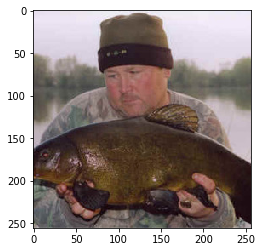

In [16]:
# An example from training -- can use such examples for testing, but from validation set
img = cv2.imread('datasets/ILSVRC2012/Training/n01440764/n01440764_10120.JPEG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

W0320 02:45:10.923021 140438808549184 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0.25258736 -0.16066595 -0.31065578]
[0.5877486  0.29570953 0.02266027]
[0.33516123 0.45637548 0.33331605]


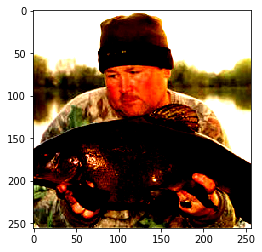

In [87]:
alphas = np.random.normal(scale=1, size=3)
shift = np.zeros(3)
for i in range(3):
    shift += alphas[i] * np.array(eigenvalues[i].tolist()) * np.array(eigenvectors[i].tolist())
prev_image = ((img-np.array(pixel_avg.tolist()))/255)/np.array(stdev.tolist())
output_image = ((img-np.array(pixel_avg.tolist()))/255 + shift)/np.array(stdev.tolist())

print(prev_image.sum(axis=0).sum(axis=0)/(256**2))
print(output_image.sum(axis=0).sum(axis=0)/(256**2))
print(shift/np.array(stdev.tolist()))
plt.imshow(output_image)

In [18]:
stdev

array([0.28336131, 0.27028511, 0.27806507])

In [22]:
# Check mean is near zero
train_gen[0][0].mean()

-0.030319863801152053

In [23]:
# Check std is less than 1
train_gen[3][0].reshape(-1,3).std(axis=0)

array([1.00564258, 1.0042937 , 1.01419677])

space shuttle


W0228 21:54:56.711154 140587054593856 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


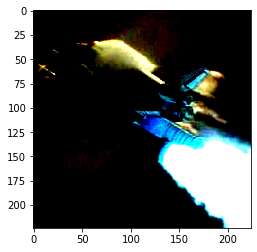

In [67]:
minibatch=4151
index=123

index_code_map 
print(code_label_map[index_code_map[train_gen[minibatch][1][index].argmax()]])
plt.imshow(train_gen[minibatch][0][index])

(224, 224, 3)
night snake, Hypsiglena torquata


W0228 22:27:55.399446 140624815589184 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


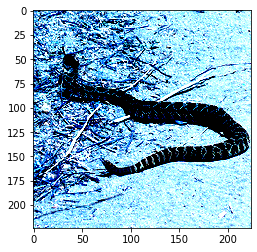

In [33]:
minibatch=50
index=23

index_code_map 
print(val_gen[minibatch][0][index].shape)
print(code_label_map[index_code_map[val_gen[minibatch][1][index].argmax()]])
plt.imshow(val_gen[minibatch][0][index])

In [28]:
train_gen[0][0][0].shape

(224, 224, 3)

W0223 22:49:06.195745 140362678523712 deprecation_wrapper.py:119] From /home/daniel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



48.25850534439087


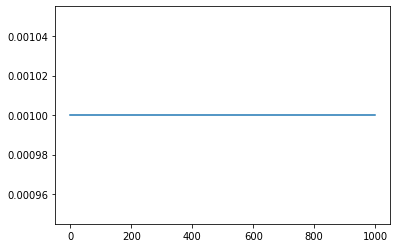

In [26]:
mean_sum = np.zeros(shape=(1000))

ti = time.time()
for index in range(100):
    mean_sum = mean_sum + alexnet.predict(train_gen[index][0]).mean(axis=0)

print(time.time()-ti)
    
plt.plot(mean_sum/100)

In [53]:
# FIXME - Changes
# Made variance of random weight init 0, all weights zero
# Normalized image pixel values by dividing by standard deviation

alexnet.evaluate_generator(val_gen, verbose=1)

391/391 [==============================] - 118s 301ms/step


[57.347755432128906, 0.0010000000474974513, 1.0]

In [62]:
# Check indices match image labels in file names.... They do...
indices = y_labels_train.argmax(axis=1)
all([index_code_map[index] == path[:9] 
     and index_code_map[index] == path[10:19] 
     for index, path in zip(indices, x_paths_train)])

True

In [114]:
a = tf.constant(alexnet.predict(train_gen[1][0]), dtype='float64')
b = tf.constant(train_gen[1][1], dtype='float64')
loss = tf.keras.backend.categorical_crossentropy(a, b, axis=1, from_logits=True)
with tf.Session() as sess:  
    print(a.eval())
    print(b.eval())
    print(loss.eval()) 

[[0.001 0.001 0.001 ... 0.001 0.001 0.001]
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]
 ...
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[6.90847241 6.90847241 6.90847241 6.90847241 6.90847241 6.90847241
 6.90847241 6.90847241 6.90847241 6.90847241 6.90847241 6.90847241
 6.90847241 6.90847241 6.90847241 6.90847241 6.90847241 6.90847241
 6.90847241 6.90847241 6.90847241 6.90847241 6.90847241 6.90847241
 6.90847241 6.90847241 6.90847241 6.90847241 6.90847241 6.90847241
 6.90847241 6.90847241 6.90847241 6.90847241 6.90847241 6.90847241
 6.90847241 6.90847241 6.90847241 6.90847241 6.90847241 6.90847241
 6.90847241 6.90847241 6.90847241 6.90847241 6.90847241 6.90847241
 6.90847241 6.90847241 6.90847241 6.90847241

In [113]:
y_true = np.array([1., 0., 0., 0., 1., 0., 0., 0., 1.]).reshape(3,3)
y_pred = np.array([.9, .05, .05, .5, .89, .6, .05, .01, .94]).reshape(3,3)
loss = -(y_true * np.log(y_pred)).sum(axis=1)
np.around(loss, 5)

array([0.10536, 0.11653, 0.06188])

In [104]:
y_pred = alexnet.predict(train_gen[1][0])
y_true = train_gen[1][1]

-(y_true * np.log(y_pred)).sum(axis=1)

array([6.90775537, 6.90775537, 6.90775537, 6.90775537, 6.90775537,
       6.90775537, 6.90775537, 6.90775537, 6.90775537, 6.90775537,
       6.90775537, 6.90775537, 6.90775537, 6.90775537, 6.90775537,
       6.90775537, 6.90775537, 6.90775537, 6.90775537, 6.90775537,
       6.90775537, 6.90775537, 6.90775537, 6.90775537, 6.90775537,
       6.90775537, 6.90775537, 6.90775537, 6.90775537, 6.90775537,
       6.90775537, 6.90775537, 6.90775537, 6.90775537, 6.90775537,
       6.90775537, 6.90775537, 6.90775537, 6.90775537, 6.90775537,
       6.90775537, 6.90775537, 6.90775537, 6.90775537, 6.90775537,
       6.90775537, 6.90775537, 6.90775537, 6.90775537, 6.90775537,
       6.90775537, 6.90775537, 6.90775537, 6.90775537, 6.90775537,
       6.90775537, 6.90775537, 6.90775537, 6.90775537, 6.90775537,
       6.90775537, 6.90775537, 6.90775537, 6.90775537, 6.90775537,
       6.90775537, 6.90775537, 6.90775537, 6.90775537, 6.90775537,
       6.90775537, 6.90775537, 6.90775537, 6.90775537, 6.90775

# Appendix A. Check Performance

Note when we run this appendix after we run the rest of the notebook we often get memory errors for larger batch sizes. We presume the additional Python objects in RAM along with the batches being loaded cause some sort of RAM OOM error. Would be interesting to look into this further at some point, we can always add more RAM to our machine.

In [45]:
# Actually just runs the benchmark below so ignore. Directory structure looks like its messed up.
!bash ../repos/lambda-tensorflow-benchmark/benchmark.sh 0 10

i9-9900KF-GeForce_RTX_2080_Ti
--optimizer=sgd --model=resnet50 --num_gpus=1 --batch_size=64 --variable_update=replicated --distortions=false --num_batches=100 --data_name=imagenet
python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=resnet50 --num_gpus=1 --batch_size=64 --variable_update=replicated --distortions=false --num_batches=100 --data_name=imagenet
python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=resnet50 --num_gpus=1 --batch_size=64 --variable_update=replicated --distortions=false --num_batches=100 --data_name=imagenet
python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=resnet50 --num_gpus=1 --batch_size=64 --variable_update=replicated --distortions=false --num_batches=100 --data_name=imagenet
python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=resnet

python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=inception4 --num_gpus=1 --batch_size=16 --variable_update=replicated --distortions=false --num_batches=100 --data_name=imagenet
python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=inception4 --num_gpus=1 --batch_size=16 --variable_update=replicated --distortions=false --num_batches=100 --data_name=imagenet
python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=inception4 --num_gpus=1 --batch_size=16 --variable_update=replicated --distortions=false --num_batches=100 --data_name=imagenet
python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=inception4 --num_gpus=1 --batch_size=16 --variable_update=replicated --distortions=false --num_batches=100 --data_name=imagenet
python3: can't open file 'tf_cnn_benchmarks.py': [Er

python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=resnet50 --num_gpus=1 --batch_size=64 --variable_update=parameter_server --distortions=false --num_batches=100 --data_name=imagenet
python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=resnet50 --num_gpus=1 --batch_size=64 --variable_update=parameter_server --distortions=false --num_batches=100 --data_name=imagenet
python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=resnet50 --num_gpus=1 --batch_size=64 --variable_update=parameter_server --distortions=false --num_batches=100 --data_name=imagenet
python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=resnet50 --num_gpus=1 --batch_size=64 --variable_update=parameter_server --distortions=false --num_batches=100 --data_name=imagenet
python3: can't open file 'tf_cnn_ben

python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=vgg16 --num_gpus=1 --batch_size=64 --variable_update=parameter_server --distortions=false --num_batches=100 --data_name=imagenet
python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=vgg16 --num_gpus=1 --batch_size=64 --variable_update=parameter_server --distortions=false --num_batches=100 --data_name=imagenet
python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=vgg16 --num_gpus=1 --batch_size=64 --variable_update=parameter_server --distortions=false --num_batches=100 --data_name=imagenet
python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=vgg16 --num_gpus=1 --batch_size=64 --variable_update=parameter_server --distortions=false --num_batches=100 --data_name=imagenet
python3: can't open file 'tf_cnn_benchmarks.py':

python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=resnet50 --num_gpus=1 --batch_size=64 --variable_update=replicated --distortions=false --num_batches=100 --data_name=imagenet --use_fp16=True
python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=resnet50 --num_gpus=1 --batch_size=64 --variable_update=replicated --distortions=false --num_batches=100 --data_name=imagenet --use_fp16=True
python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=resnet152 --num_gpus=1 --batch_size=32 --variable_update=replicated --distortions=false --num_batches=100 --data_name=imagenet --use_fp16=True
python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=resnet152 --num_gpus=1 --batch_size=32 --variable_update=replicated --distortions=false --num_batches=100 --data_name=imagenet --use_fp16

python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=vgg16 --num_gpus=1 --batch_size=64 --variable_update=replicated --distortions=false --num_batches=100 --data_name=imagenet --use_fp16=True
python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=vgg16 --num_gpus=1 --batch_size=64 --variable_update=replicated --distortions=false --num_batches=100 --data_name=imagenet --use_fp16=True
python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=vgg16 --num_gpus=1 --batch_size=64 --variable_update=replicated --distortions=false --num_batches=100 --data_name=imagenet --use_fp16=True
python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=vgg16 --num_gpus=1 --batch_size=64 --variable_update=replicated --distortions=false --num_batches=100 --data_name=imagenet --use_fp16=True
python3:

python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=resnet50 --num_gpus=1 --batch_size=64 --variable_update=parameter_server --distortions=false --num_batches=100 --data_name=imagenet --use_fp16=True
python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=resnet50 --num_gpus=1 --batch_size=64 --variable_update=parameter_server --distortions=false --num_batches=100 --data_name=imagenet --use_fp16=True
python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=resnet152 --num_gpus=1 --batch_size=32 --variable_update=parameter_server --distortions=false --num_batches=100 --data_name=imagenet --use_fp16=True
python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=resnet152 --num_gpus=1 --batch_size=32 --variable_update=parameter_server --distortions=false --num_batches=100 --data_

--optimizer=sgd --model=vgg16 --num_gpus=1 --batch_size=64 --variable_update=parameter_server --distortions=false --num_batches=100 --data_name=imagenet --use_fp16=True
python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=vgg16 --num_gpus=1 --batch_size=64 --variable_update=parameter_server --distortions=false --num_batches=100 --data_name=imagenet --use_fp16=True
python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=vgg16 --num_gpus=1 --batch_size=64 --variable_update=parameter_server --distortions=false --num_batches=100 --data_name=imagenet --use_fp16=True
python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory
--optimizer=sgd --model=vgg16 --num_gpus=1 --batch_size=64 --variable_update=parameter_server --distortions=false --num_batches=100 --data_name=imagenet --use_fp16=True
python3: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such fi

In [6]:
!python ../repos/benchmarks/scripts/tf_cnn_benchmarks/tf_cnn_benchmarks.py --num_gpus=1 --batch_size=128 --model=alexnet --variable_update=parameter_server --use_fp16=False --datasets_use_prefetch=False --data_name imagenet

W0219 22:38:18.301284 140239143397184 deprecation.py:323] From /home/daniel/anaconda3/lib/python3.7/site-packages/tensorflow/python/compat/v2_compat.py:61: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term
2020-02-19 22:38:18.303619: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2020-02-19 22:38:18.326465: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3600000000 Hz
2020-02-19 22:38:18.327209: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5635c0900530 executing computations on platform Host. Devices:
2020-02-19 22:38:18.327219: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2020-02-19 22:38:18.327765: I tensorflo

2020-02-19 22:38:18.885718: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.
I0219 22:38:19.280107 140239143397184 session_manager.py:500] Running local_init_op.
I0219 22:38:19.287192 140239143397184 session_manager.py:502] Done running local_init_op.
Running warm up
2020-02-19 22:38:19.379757: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcublas.so.10
2020-02-19 22:38:19.573685: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcudnn.so.7
Done warm up
Step	Img/sec	total_loss
1	images/sec: 3